In [1]:
# Code for the 2.4um, 65fs, 2.2mJ laser at UCF
#Two stages: first compression, second tuning of an RDW emission in the UV/Vis

In [2]:
#=
first section (275 lines) has all the functions (external to Luna) and variables/parameters used
second section is where the first fiber is simulated: the spectra is broadened, then compressed in time with components in prop1! to 17.5 fs
third section is where the second stage is simulated and hopefully RDW is emitted based on entered gas, pressure, and energy
fourth section allows you to zoom into specfic areas from second stage to analyze through graphs
fifth section is an energy scan for a set pressure of the second stage
=#

In [3]:
using Luna  #declare package to use propagation functions, need to add to Julia REPL before first use, see GitHub for documentation
import PyPlot as plt #for some plotting
using Plots #for some other plotting
gr() #backend for Plots
using LinearAlgebra #for central wavelength calculation

# ##global variables:
    #parameters of input pulse using the 2.4um laser
    λ0 = 2400e-9	    #central wavelength in meters
    τfwhm_initial= 65e-15	#pulse duration in seconds
    #parameters of the first fiber
    a1 = 268e-6		#core radius in meters
    flength1 = 1 	#fiber length in meters
    gas1 = :Kr		#gas in the fiber, Kr is krypton 
    energy1 = 500e-6	#pulse energy in Joules
    pressure1 = 1.0		#gas pressure in bar
    #parameters of the second fiber
    a2 = 175e-6		#core radius in meters
    flength2 = 1.0	#fiber length in meters
    compressor_stg1 =  Array{Any}(undef,1) #only using the first index but need array since mutuable in/out of functions
    compressor_stg2 =  Array{Any}(undef,6) #one index for each tested output pulse duration
    #plotting/grid parameters
    FTL=false #turns off the transformed limited case
    modes= 4 		 #total number of modes
    trange1 = 300e-15 	    #time grid size in seconds
    λrange1= (100e-9, 0.9λ0) #grid wavelength range in meters for plots for graphs
    λlims_stg1 = (100e-9, 1.1λ0) #grid wavelength range in meters for fibers for propagation
    trange2 = 1000e-15  	    #time grid size in seconds 
    λlims_stg2 =(150e-9, 2λ0) #grid wavelength range in meters for fibers for propagation
    a=1 #arbituary array index to easily make variables mutuable for functions
    λ00=Array{Any}(undef,6) #for central wavelength

##functions:

#return central wavelength for given length in fiber for given wavelegnth range
function get_central_wavelength(i,specrange, flength, func)
    λ, Iλ=Processing.getIω(func,:λ, flength; specrange) #get arrays from output SED for wavelengths in specrange at flength
    Iλd=Iλ[:,1,1] #only 1st mode
    P=LinearAlgebra.dot(λ[:], Iλd[:]) #calculate central wavelength: (1/TotalPower)*sum(λ*SED)
    λ00[i]=P/sum(Iλd)
end

#:::'##::::'######::'########:::::'######::'########::::'###:::::'######:::'########:
#:'####:::'##... ##:... ##..:::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
#:.. ##::: ##:::..::::: ##::::::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
#::: ##:::. ######::::: ##:::::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
#::: ##::::..... ##:::: ##::::::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
#::: ##:::'##::: ##:::: ##:::::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
#:'######:. ######::::: ##:::::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
#:......:::......::::::..:::::::::......::::::..:::::..:::::..:::......::::........::

#simulates the pulse down the first fiber
function stg1(gas, energy, pressure)
    pulse_in_stg1=Pulses.GaussPulse(;λ0, τfwhm=τfwhm_initial, energy=energy, power=nothing, ϕ=Float64[], m=1,mode=:lowest, polarisation=:linear, propagator=prop1!)
    #propagate through the first stage fiber to broaden bandwidth with the parameters listed above
    compressor_stg1[1]= prop_capillary(a1, flength1, gas, pressure; pulses=[pulse_in_stg1], λ0=λ0, trange=trange1, λlims=(100e-9, 1.1λ0), modes=modes)
end
        
function prop1!(Eω, grid) # this mutates its input as required for the LunaPulse
     Fields.prop_material!(Eω, grid, :SiO2, 1e-3, λ0) # 1 1-mm window
     Fields.prop_material!(Eω, grid, :Air, 1, λ0) # 2m of air
    Fields.prop_material!(Eω, grid, :KBr, 5e-3, λ0) # 1 1-mm window
   _, Eωopt = Fields.optcomp_material(Eω, grid, :SiO2, λ0, -2e-2, 2e-2) #wedges for optimizing compression, last numbers are  min_thickness then max_thickness
   Eω .= Eωopt
 end
    
# non-mutating version of prop! as required for plotting
function prop1(grid, Eω)
    Eωout = copy(Eω)
    prop1!(Eωout, grid)
    Eωout
end

#:'#######::'##::: ##:'########::::::'######::'########::::'###:::::'######:::'########:
#'##.... ##: ###:: ##: ##.... ##::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
#..::::: ##: ####: ##: ##:::: ##:::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
#:'#######:: ## ## ##: ##:::: ##::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
#'##:::::::: ##. ####: ##:::: ##:::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
# ##:::::::: ##:. ###: ##:::: ##::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
# #########: ##::. ##: ########:::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
#.........::..::::..::........:::::::......::::::..:::::..:::::..:::......::::........::

#simulates the pulse down the second fiber
function stg2(a, a2, gas, energy, pressure) 
    #obtain pulse from the first fiber end via LunaPulse
     pulse_in_stg2 = Pulses.LunaPulse(compressor_stg1[1]; energy, propagator=prop1!) #input pulse from the 1st stage
    #propagate through the second stage fiber to broaden bandwidth even more, with parameters listed above
    compressor_stg2[a]= prop_capillary(a2, flength2, gas, pressure; pulses=[pulse_in_stg2], λ0=λ0, trange=trange2, λlims=λlims_stg2, modes=modes)
end

#compress in time the second stage with chirp mirrors and other optical components
#=physical order in lab: First fiber>optical components>second fiber> 1mm fused silica window >4-5 m of air path length >1mm MgF2 window> 4 (2 pairs) of PC147 chirped mirrors from ultrafast innovations 6 (3 pairs) of PC147 chirped mirrors from ultrafast innovations  > 3.5mm fused silica polarizer > wedges >third fiber     =#
#this mutates its input as required for the LunaPulse
function prop2!(Eω, grid)
    Fields.prop_material!(Eω, grid, :SiO2, 1e-3, λ0) # 1 1-mm fused silica window 
    Fields.prop_material!(Eω, grid, :Air, 3.9, λ0) # 4m of air total
    Fields.prop_material!(Eω, grid, :MgF2, 1e-3, λ0) #1mm Magnesium Fluoride window
    Fields.prop_material!(Eω, grid, :SiO2, 3.5e-3, λ0) # 1 3.5 mm fused silica polarizer
  _, Eωopt = Fields.optcomp_material(Eω, grid, :MgF2, λ0, -1e-2, 1e-2) #wedges for optimizing compression, last numbers are  min_thickness then max_thickness
  Eω .= Eωopt
end

# non-mutating version of prop! as required for plotting
function prop2(grid, Eω)
    Eωout = copy(Eω)
    prop2!(Eωout, grid)
    Eωout
end


#:'######:::'########:::::'###::::'########::'##::::'##::'######::
#'##... ##:: ##.... ##:::'## ##::: ##.... ##: ##:::: ##:'##... ##:
# ##:::..::: ##:::: ##::'##:. ##:: ##:::: ##: ##:::: ##: ##:::..::
# ##::'####: ########::'##:::. ##: ########:: #########:. ######::
# ##::: ##:: ##.. ##::: #########: ##.....::: ##.... ##::..... ##:
# ##::: ##:: ##::. ##:: ##.... ##: ##:::::::: ##:::: ##:'##::: ##:
#. ######::: ##:::. ##: ##:::: ##: ##:::::::: ##:::: ##:. ######::
#:......::::..:::::..::..:::::..::..:::::::::..:::::..:::......::

#graphs before compression 
function graphs_b4(func, range, bandpasss, TF) 
    Plotting.time_1D(func; modes=1,  FTL=FTL, trange=(-300e-15, 300e-15), bandpass=bandpasss) 		
        #^^plot of power as function of time for the mode specified 
         #can add bandpass= to look at pulse duration for certain wavelegnths
    Plotting.spec_1D(func; log10=TF, modes=1,  λrange=range)
        #^^ plots SED as function of wavelength for each mode
   # Plotting.stats(func)
        #^^ plots lots of info about each mode
 #   Plotting.energy(func; modes=1, bandpass=bandpasss)
        #^^ graphs the energy as a function of distance for given wavelength range
end

#graphs after compression 
function graphs_after(func, propp, range, bandpasss, TF) #where propp corresponds to prop1, or prop2 for compression
    Plotting.time_1D(func; modes=1, trange=(-300e-15, 300e-15), FTL=FTL, propagate=propp, bandpass=bandpasss) 		
        #^^plot of power as function of time for the mode specified 
        #can add bandpass= to look at pulse duration for certain wavelegnths
    Plotting.spec_1D(func; log10=TF, modes=1, λrange=range)
        #^^ plots SED as function of wavelength for each mode
#     Plotting.stats(func)
#         #^^ plots lots of info about each mode
#     Plotting.energy(func; modes=1, bandpass=bandpasss)
#     #^^ graphs the energy as a function of distance for given wavelength range
end

#graphs the normalized SED vs wavelength, based on for loop from stg3
#some arrays may need the wavelegnth to be cut off later/sooner than the 1300
function graphs2_normSED_λ(func, j, a, pt1)
    #general plotting parameters
    xlims= (100, 500)
    xlabel="Wavelength (nm)"
    ylims= (0,1)
    ylabel= "Normalized Spectral energy density"
    title="Normalized SED vs λ with varying gas and pressure"
    y=0 #fills under the curve in solid color
    #plotting arrays/variables
    λ= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    λ[j], Iλ[j]=Processing.getIω(compressor_stg3[a, j], :λ,1) #get values of from the compressor function
    λ[j]=first(λ[j],1300) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 1300) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plot!(pt1, λ[j]*1e9, Iλ_norm[j], fillrange=y, title=title, xlims=xlims, xlabel=xlabel, ylabel=ylabel, ylims=ylims, color="$(color[j])")
end


#graphs the normalized SED vs angular frequnecy, based on for loop from stg3
function graphs2_normSED_ω(func, j)
    
    #general plotting parameters
    plt.xlim(10e14, 30e14)
    plt.xlabel("Angular Frequency (rad/s)")
    plt.ylabel("Normalized Spectral energy density")
    plt.ylim(0,1)
    plt.title("Normalized SED vs Angular Frequency with varying gas and pressure")

    #plotting arrays/variables
    w= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    w[j], Iλ[j]=Processing.getIω(compressor_stg3[a, j], :ω,1) #get values of from the compressor function
    w[j]=first(w[j],1300) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 1300) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot(w[j], Iλ_norm[j], label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")
end

#graphs the normalized SED vs frequnecy, based on for loop from stg3
function graphs2_normSED_f(func, j)
    #general plotting parameters
    plt.xlim(100, 500)
    plt.xlabel("Frequency (THz)")
    plt.ylabel("Normalized Spectral energy density")
    plt.ylim(0,1)
    plt.title("Normalized SED vs Frequency with varying gas and pressure")

    #plotting arrays/variables
    f= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    f[j], Iλ[j]=Processing.getIω(func, :f,1) #get values of from the compressor function
    f[j]=first(f[j],1300) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 1300) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot(f[j]*1e-12, Iλ_norm[j], label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")
end

#graphs the normalized SED vs frequnecy, based on for loop from stg3
function graphs2_normSED_e(func,a, j)
        #general plotting parameters
    plt.xlim(0, 9)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Normalized Spectral energy density")
    plt.ylim(0,1)
    plt.title("Normalized SED vs Energy with varying gas and pressure")

    #plotting arrays/variables
    f= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    f[j], Iλ[j]=Processing.getIω(func, :f,1) #get values of from the compressor function
    print(size(f[j]))
    f[j]=first(f[j],1300) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 1300) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot(f[j]*4.14e-15, Iλ_norm[j], label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")
    print(size(f[j]))

end

#graphs the normalized SED vs frequnecy, based on for loop from stg3
function graphs2_normSED_ezoom(func,a, j)
        #general plotting parameters
    plt.xlim(6, 9)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Normalized Spectral energy density")
    plt.ylim(0,1)
    plt.title("Normalized SED vs Energy with varying gas and pressure")

    #plotting arrays/variables
    f= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    f[j], Iλ[j]=Processing.getIω(func, :f,1) #get values of from the compressor function
   # print(size(f[j]))
    f[j]=last(f[j],1000) #filter out data points greater than window to normalize properly
    Iλ[j]=last(Iλ[j], 1000) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot(f[j]*4.14e-15, Iλ_norm[j], label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")
end

graphs2_normSED_ezoom (generic function with 1 method)

[ Info: X+Y polarisation not required.
[ Info: Freq limits 0.11 - 3.00 PHz
[ Info: Samples needed: 5396.26, samples: 8192, δt = 55.59 as
[ Info: Requested time window: 300.0 fs, actual time window: 455.4 fs
[ Info: Grid: samples 4096 / 8192, ωmax 2.83e+16 / 5.65e+16
[ Info: Using PPT ionisation rate.
[ Info: Found cached PPT rate for 13.992094691484 eV, 2400.0 nm
[ Info: Using radial modal integral.
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Starting propagation
[ Info: Progress: 2.93 %, ETA: 00:02:46, stepsize 1.31e-03, err 0.25, repeated 0
[ Info: Progress: 12.59 %, ETA: 00:01:11, stepsize 1.37e-03, err 0.21, repeated 0
[ Info: Progress: 24.38 %, ETA: 00:00:47, stepsize 1.43e-03, err 0.31, repeated 0
[ Info: Progress: 33.09 %, ETA: 00:00:41, steps

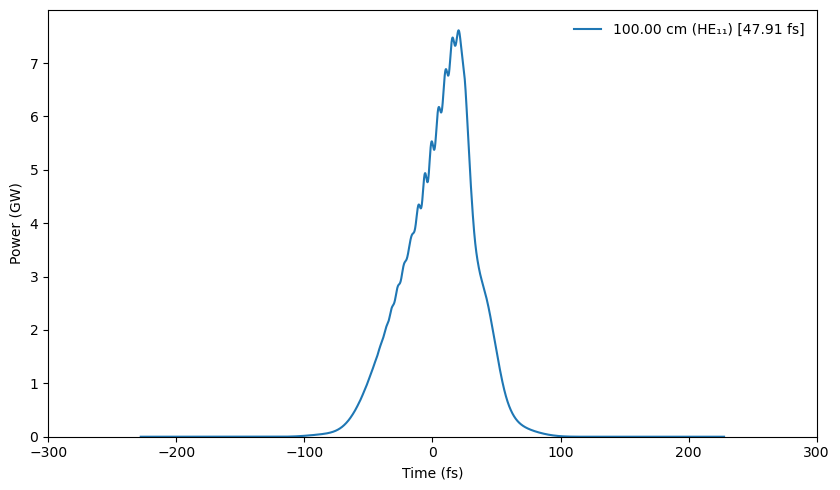

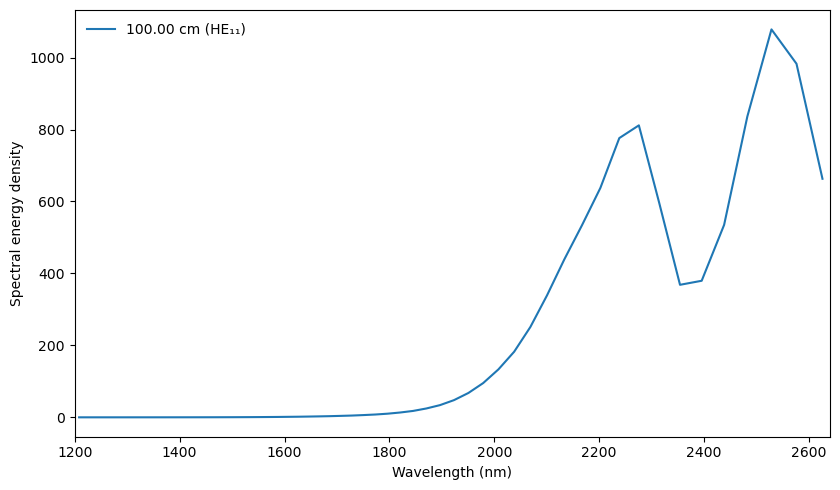

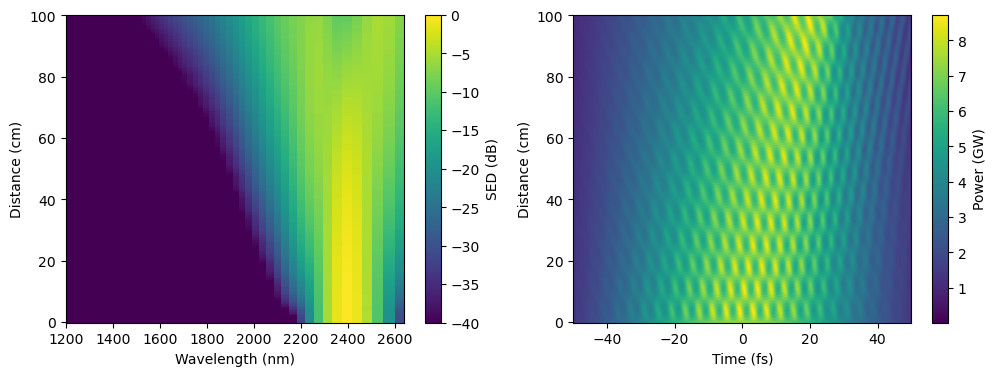

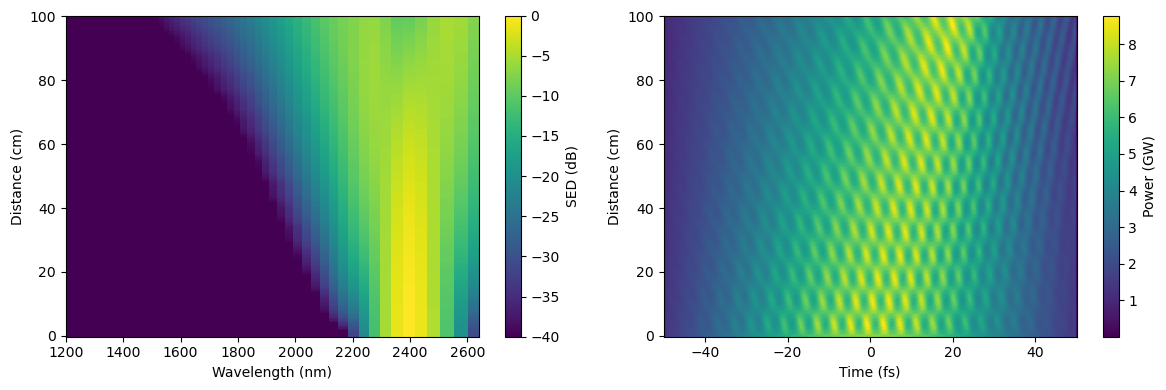

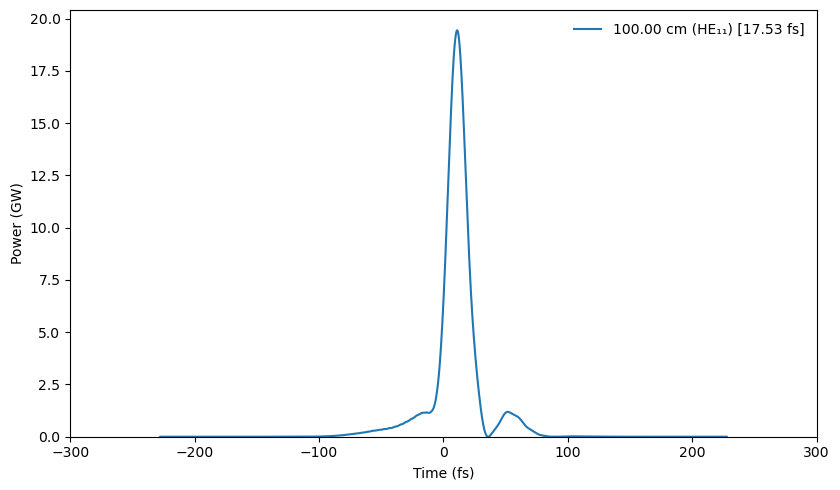

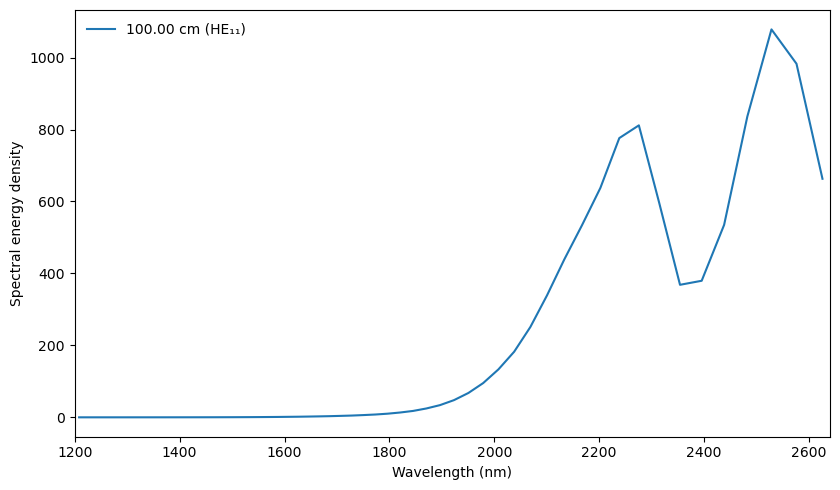

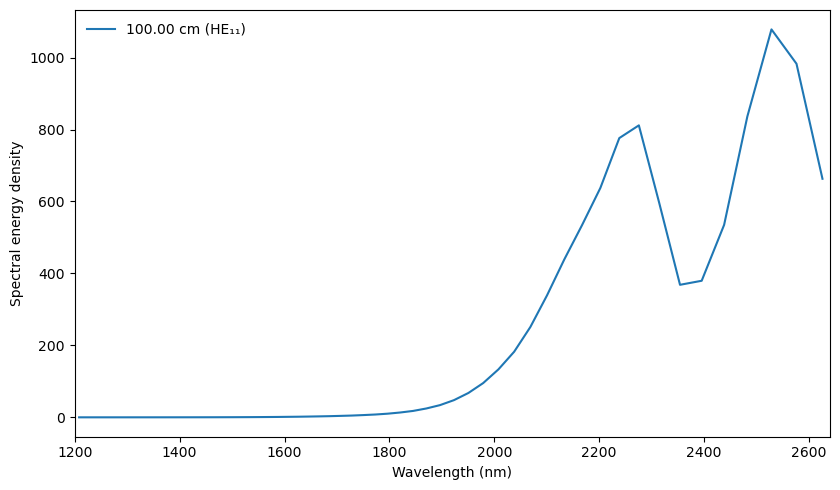

In [4]:
#:::'##::::'######::'########:::::'######::'########::::'###:::::'######:::'########:
#:'####:::'##... ##:... ##..:::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
#:.. ##::: ##:::..::::: ##::::::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
#::: ##:::. ######::::: ##:::::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
#::: ##::::..... ##:::: ##::::::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
#::: ##:::'##::: ##:::: ##:::::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
#:'######:. ######::::: ##:::::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
#:......:::......::::::..:::::::::......::::::..:::::..:::::..:::......::::........::
bandpass=(0.5λ0, 1.1λ0) #for time graphs
λrange1=bandpass #for wavelength graphs

stg1(gas1, energy1, pressure1) #use predefined function to simulate pulse down first fiber
graphs_b4(compressor_stg1[1], λrange1, bandpass, false) #plot pulse after first fiber before compression- function, predefined λrange in global variables; last parameter sets log scale to true or false
Plotting.prop_2D(compressor_stg1[1], :λ, dBmin=-40.0,  λrange=λrange1, modes=1) #graphs color map of wavlength vs distance
graphs_after(compressor_stg1[1], prop1, λrange1, bandpass, false) #plot pulse after compression - prop1 for first fiber, predefined λrange in global variables 

[ Info: X+Y polarisation not required.
[ Info: Freq limits 0.06 - 2.00 PHz
[ Info: Samples needed: 11991.70, samples: 16384, δt = 83.39 as
[ Info: Requested time window: 1000.0 fs, actual time window: 1366.3 fs
[ Info: Grid: samples 8192 / 16384, ωmax 1.88e+16 / 3.77e+16
[ Info: Using PPT ionisation rate.
[ Info: Found cached PPT rate for 15.760834782784002 eV, 2400.0 nm
[ Info: Using radial modal integral.
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
┌ Warning: Interpolating onto a coarser grid may clip the input spectrum.
└ @ Luna.Fields C:\Users\kinca\.julia\packages\Luna\cyPdO\src\Fields.jl:240
┌ Warning: Interpolating onto a coarser grid may clip the input spectrum.
└ @ Luna.Fields C:\Users\kinca\.julia\packages\Luna\cyPdO\src\Fields.jl:240
┌ Warning: Interpolating onto a coarser grid may clip the input spectrum.
└ @ Luna.Fields C:\Users\kinca\.julia\packages\Luna\cyPdO\src\Fields.jl:240
┌ Warning: Interpolating onto a coarser grid may clip the input spectr

[ Info: Progress: 80.10 %, ETA: 00:01:06, stepsize 4.20e-04, err 0.21, repeated 0
[ Info: Progress: 80.75 %, ETA: 00:01:05, stepsize 4.54e-04, err 0.19, repeated 0
[ Info: Progress: 81.51 %, ETA: 00:01:03, stepsize 4.60e-04, err 0.23, repeated 0
[ Info: Progress: 82.14 %, ETA: 00:01:01, stepsize 4.58e-04, err 0.20, repeated 0
[ Info: Progress: 82.69 %, ETA: 00:01:00, stepsize 4.52e-04, err 0.23, repeated 0
[ Info: Progress: 83.31 %, ETA: 00:00:59, stepsize 4.40e-04, err 0.22, repeated 0
[ Info: Progress: 83.88 %, ETA: 00:00:57, stepsize 4.31e-04, err 0.21, repeated 0
[ Info: Progress: 84.49 %, ETA: 00:00:56, stepsize 4.47e-04, err 0.20, repeated 0
[ Info: Progress: 85.14 %, ETA: 00:00:54, stepsize 4.85e-04, err 0.20, repeated 0
[ Info: Progress: 85.86 %, ETA: 00:00:52, stepsize 4.69e-04, err 0.22, repeated 0
[ Info: Progress: 86.71 %, ETA: 00:00:49, stepsize 4.73e-04, err 0.22, repeated 0
[ Info: Progress: 87.37 %, ETA: 00:00:47, stepsize 4.66e-04, err 0.22, repeated 0
[ Info: Progress

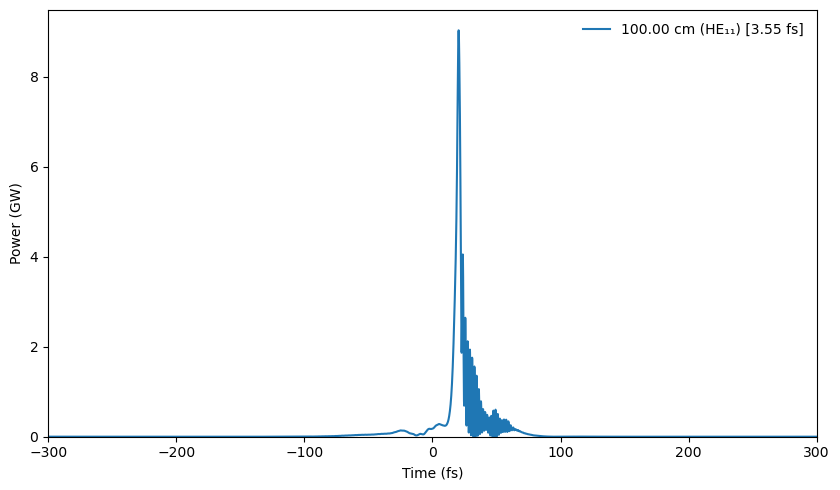

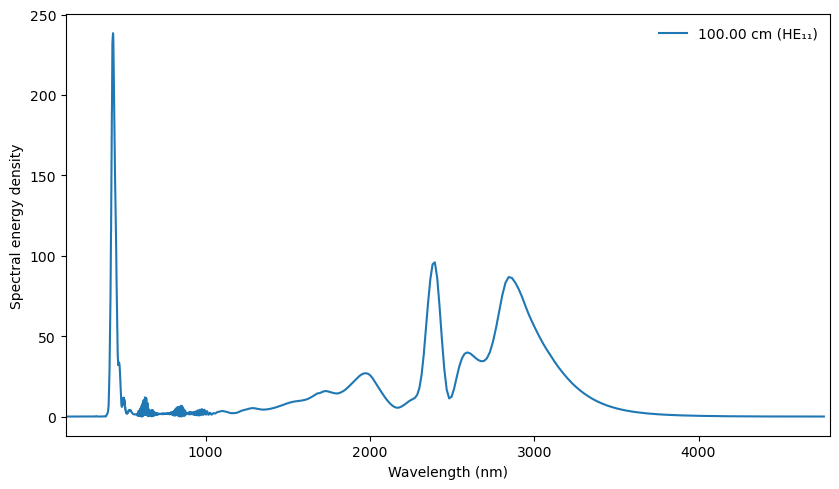

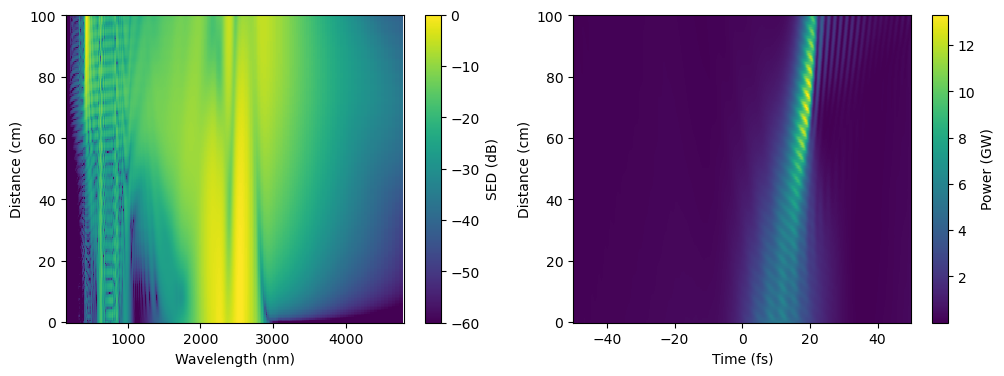

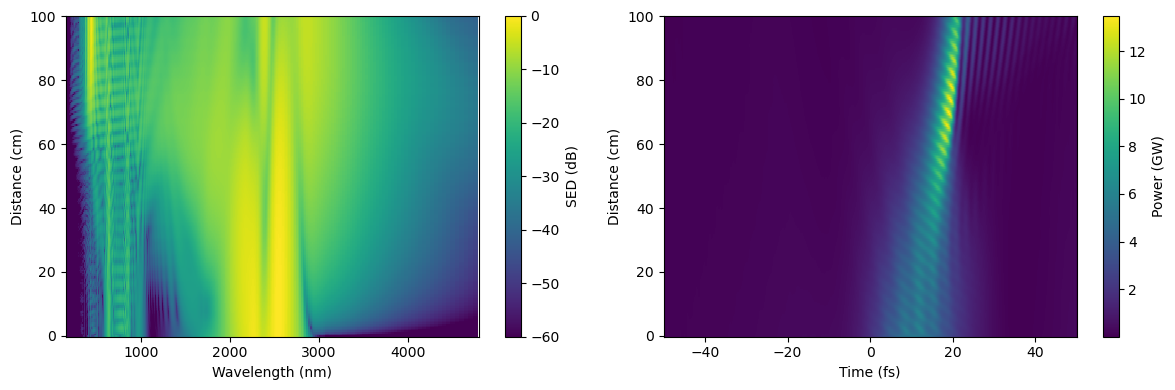

2-element Vector{PyPlot.Figure}:
 PyPlot.Figure(PyObject <Figure size 1200x400 with 4 Axes>)
 PyPlot.Figure(PyObject <Figure size 1200x400 with 4 Axes>)

In [23]:
#:'#######::'##::: ##:'########::::::'######::'########::::'###:::::'######:::'########:
#'##.... ##: ###:: ##: ##.... ##::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
#..::::: ##: ####: ##: ##:::: ##:::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
#:'#######:: ## ## ##: ##:::: ##::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
#'##:::::::: ##. ####: ##:::: ##:::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
# ##:::::::: ##:. ###: ##:::: ##::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
# #########: ##::. ##: ########:::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
#.........::..::::..::........:::::::......::::::..:::::..:::::..:::......::::........::
λrange2 = (150e-9, 2*λ0) #for frequency graphs
bandpass2=λrange2 #for time graphs

gas2=  :Ar #gas in the fiber, Ar is argon, He is Helium, Ne is Neon, Kr is Krypton
energy2= 120e-6 #in joules
pressure2= 1.7 #in bar

stg2(a, a2, gas2, energy2, pressure2) #simulate second fiber
graphs_b4(compressor_stg2[a], λrange2, bandpass2, false) #plot pulse after second fiber
Plotting.prop_2D(compressor_stg2[a], :λ, λrange=λrange2, modes=1) #graphs color map of wavlength vs distance


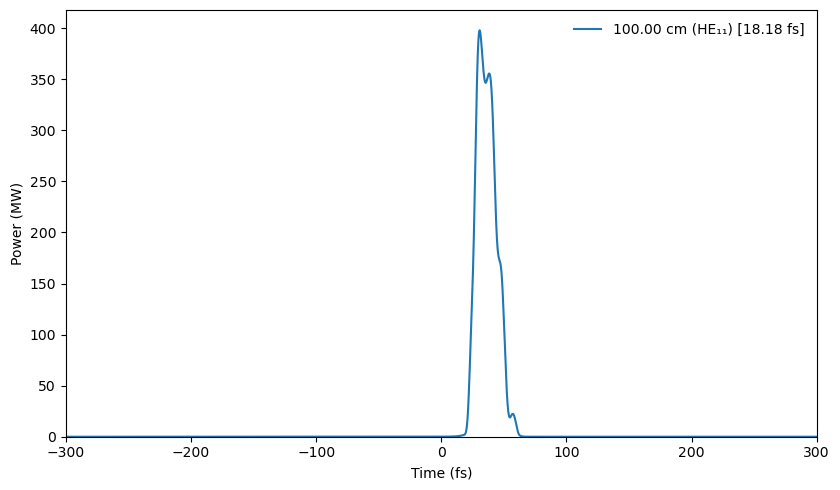

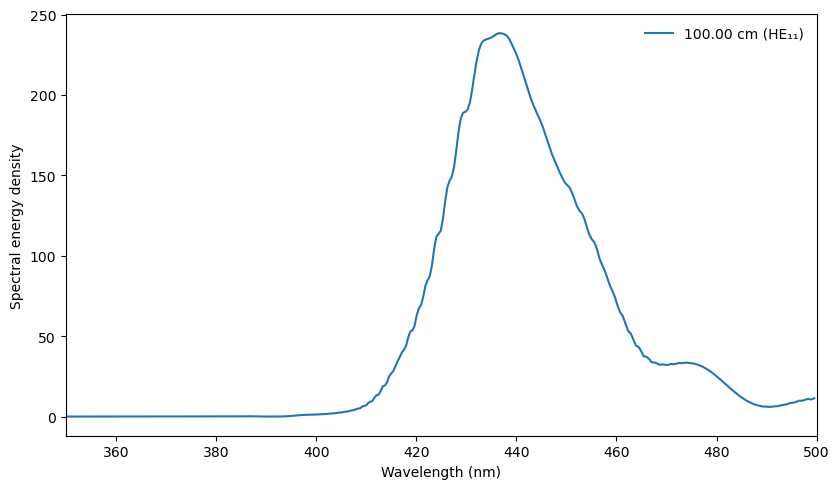

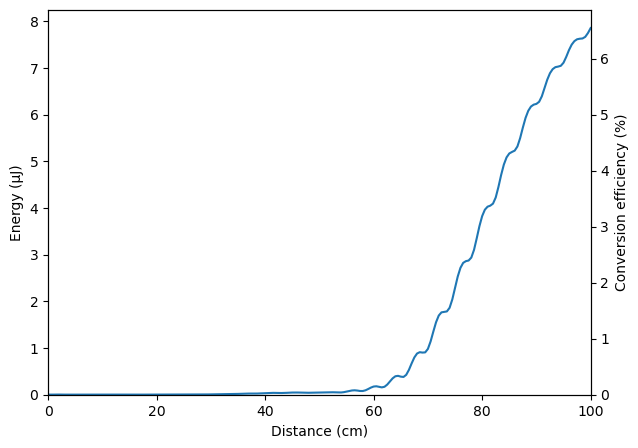

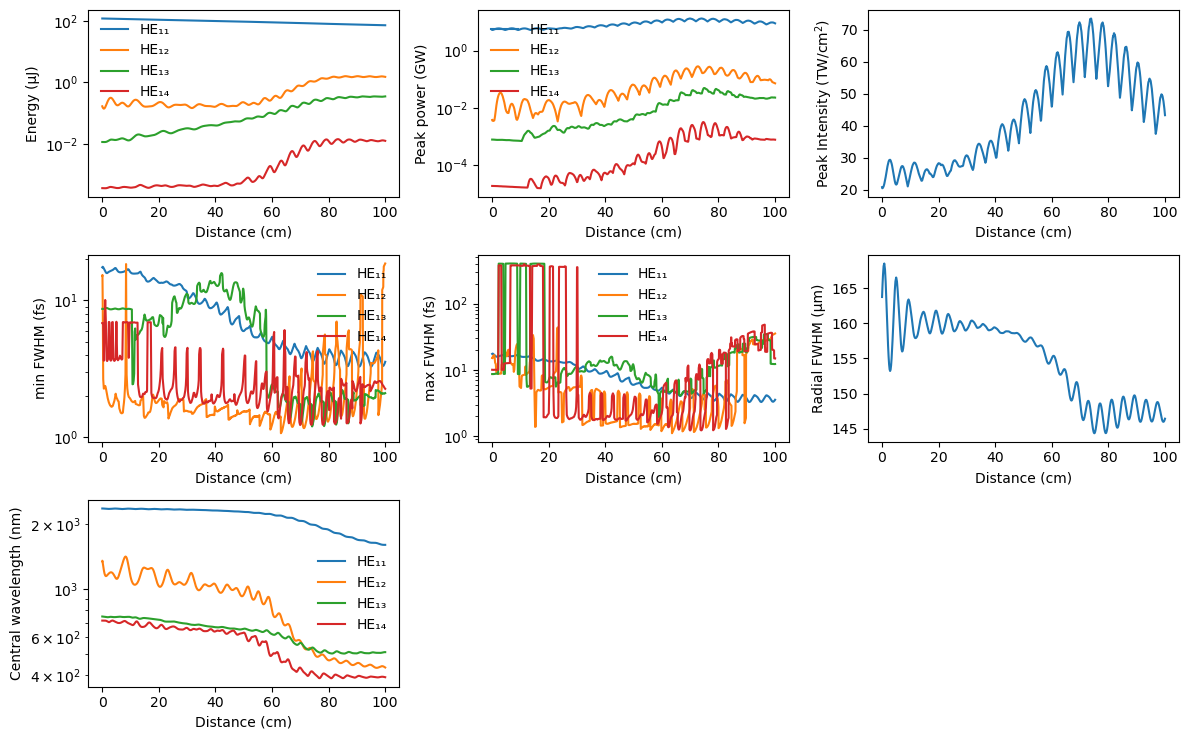

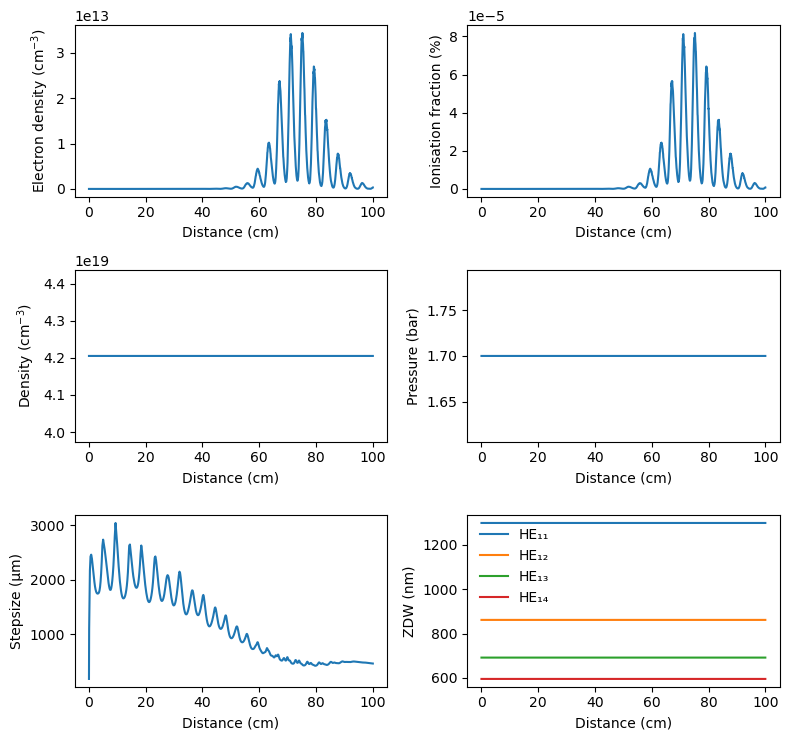

2-element Vector{PyPlot.Figure}:
 PyPlot.Figure(PyObject <Figure size 1200x750 with 7 Axes>)
 PyPlot.Figure(PyObject <Figure size 800x750 with 6 Axes>)

In [25]:
#zoom in to specific areas from simulation and analyze through graphs
λrange2 = (350e-9, 500e-9) #for frequency graphs
bandpass2=λrange2 #for time graphs

graphs_b4(compressor_stg2[a], λrange2, bandpass2, false) #plot pulse after second fiber
Plotting.energy(compressor_stg2[a]; modes=1, bandpass=bandpass2) #graphs energy and energy conversion in range of bandpass
Plotting.stats(compressor_stg2[a]) #graphs lots of info for each mode, such as energy/peak_power/peak_intensity/FWHM/λzd/ionisation_fraction/electron_density vs distance, , 

In [17]:
# #scan range of energies for specfic pressure and output time/frequency graphs

# pressure1=2.5 #set pressure value in bar
# gas1=:Ne #gas
# energy_scan1=120e-6 #beginning value of scan
# energy_scan2=200e-6 #last value of scan
# scan_steps=20e-6 #step to increment the scanned variables
# x=energy_scan1 #set first value of for loop

# bandpass= (100e-9, 0.9λ0) #for time graphs
# λrange1=bandpass #for wavelength graphs

# for x in energy_scan1:scan_steps:energy_scan2
#     stg1(gas1, x, pressure1) #use predefined function to simulate pulse down first fiber
#     graphs_b4(compressor_stg2[a], λrange1, bandpass, false) #output time and frequency graphs based on limits of λrange1 and bandpass
#     Plotting.energy(compressor_stg2[a], bandpass=(100e-9, 500e-9))
#     Plotting.prop_2D(compressor_stg2[a], :λ, dBmin=-40.0,  λrange=λrange1, modes=1) #output color graph of wavelength vs distance
# end